# Force Computation

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group),target_fix


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs


# Load the data

In [69]:

folder = "D:data OT - TT//TotalData//"
npoints   =  20000
target, x_data, y_data, sum_data, particle_group,target_fix = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [70]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

# Equipartition method

In [71]:
#Constants
calibration_factor_x = 1.2523639992636278e-6 #m/V
calibration_factor_y = 1.5930991659754123e-6 #m/V

#boltzmann constant
k_b = 1.38064852*10**(-23) #J K^-1

#absolute temperature = 
T = 295.15 #K

In [72]:
def normalize(xdata,ydata,sumdata):
    """
    Normalize the signals to the sum intensity.
    """
    new_xdata = xdata/sumdata
    new_ydata = ydata/sumdata
    
    return new_xdata, new_ydata

def calibration(xdata,ydata):
    """
    Transforms the intensity data to position data
    """
    new_xdata = xdata * calibration_factor_x
    new_ydata = ydata * calibration_factor_y
    
    return new_xdata, new_ydata

def stiffness(xdata,ydata):
    """
    Computes the stiffness of the trap
    """
    
    kx = k_b*T/np.var(xdata)
    ky = k_b*T/np.var(ydata)
    return kx, ky


In [73]:
particle_label= []
kx_list = []
ky_list = []
for ind in range(0,len(x_data)):
    
    kx_list_particle=[]
    ky_list_particle=[]

    for i in range(0,len(x_data[ind])):
        xdata0 = x_data[ind][i]
        ydata0 = y_data[ind][i]
        sumdata0 = sum_data[ind][i]

        #normalization
        xdata, ydata = normalize(xdata0,ydata0,sumdata0)

        #calibration of the position
        xdata, ydata = calibration(xdata, ydata)

        #stiffness
        kx, ky = stiffness(xdata, ydata)
        kx_list_particle.append(kx)
        ky_list_particle.append(ky)
        #print(target_fix[ind])
        #print("kx = " + str(kx))
        #print("ky = " + str(ky))
    
    kx_list.append(kx_list_particle)
    ky_list.append(ky_list_particle)
    particle_label.append(target_fix[ind])
    
    print(target_fix[ind])    
    print("kx = " + str(np.mean(kx)))
    print("ky = " + str(np.mean(ky)))

3umPMMA
kx = 5.038130010033812e-05
ky = 8.392672729758752e-05
3umPMMA
kx = 0.00010752131496480268
ky = 5.203904615137864e-05
3umPMMA
kx = 0.00041191189204574564
ky = 2.2069944302125807e-05
3umPMMA
kx = 5.577104583203333e-05
ky = 8.962658339774267e-05
3umPMMA
kx = 9.370921449483415e-05
ky = 0.00018749893415146446
3umPMMA
kx = 0.0001705268683876906
ky = 0.0003034813132875477
3umPOLY
kx = 2.8846357275149113e-05
ky = 1.8281517553531543e-05
3umPOLY
kx = 3.363328237026834e-05
ky = 1.867864564646695e-05
3umPOLY
kx = 2.4517285796965598e-05
ky = 2.215895396354622e-05
3umPOLY
kx = 7.340636843749363e-05
ky = 2.10310078938386e-05
3umPOLY
kx = 0.0002081565410641645
ky = 1.5085996315790181e-05
3umPOLY
kx = 5.43979645022921e-05
ky = 1.199776185430355e-05
4umPOLY
kx = 0.00025426305400228736
ky = 0.00014350564434465897
4umPOLY
kx = 0.00024818692159447604
ky = 0.00023794945936839512
4umPOLY
kx = 0.0003071985018134795
ky = 7.785023990606923e-05
4umPOLY
kx = 0.00012257492282727146
ky = 4.124013634414577e-

In [74]:
#Print summary table


In [75]:

label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(particle_label==label0)[0]
i1= np.where(particle_label==label1)[0]
i2= np.where(particle_label==label2)[0]
i3= np.where(particle_label==label3)[0]
i4= np.where(particle_label==label4)[0]
i5= np.where(particle_label==label5)[0]


# Stiffness Plots

<IPython.core.display.Javascript object>


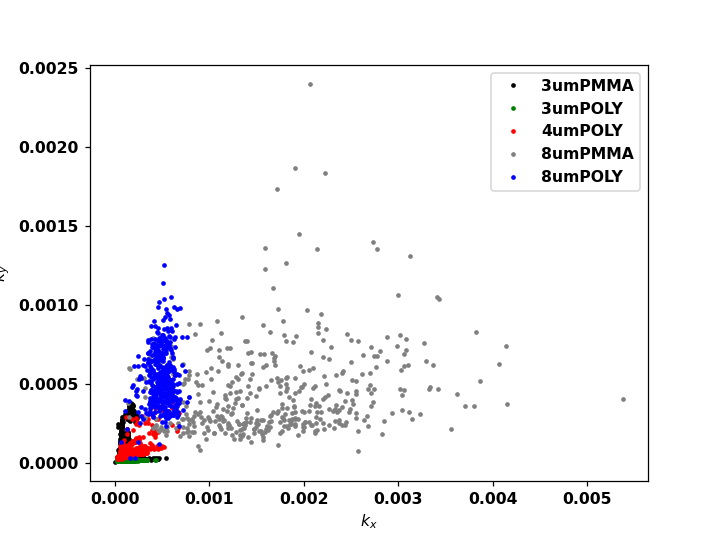

Text(0, 0.5, '$k_y$')

In [80]:
%matplotlib notebook
subplots()
ms=2

s0=0
s1=0
s2=0
s3=0
s4=0
s5=0

for i in range(0,len(ky_list)):    
    
    if particle_label[i]==label0:
        if s0 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'k', label=label0)
            s0=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'k')
    
    elif particle_label[i]==label1:
        
        if s1 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'g', label=label1)
            s1=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'g')
        
        
    elif particle_label[i]==label2:
        
        if s2 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'r', label=label2)
            s2=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'r')
            
    
    elif particle_label[i]==label3:
        
        if s3 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'grey', label=label3)
            s3=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'grey')
    
    elif particle_label[i]==label4:
        
        if s4 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'b', label=label4)
            s4=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'b')

    """
    elif particle_label[i]==label5:
        
        if s5 == 0:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'y', label=label5)
            s5=1
        else:
            plot(kx_list[i],ky_list[i],'o',ms=ms, color = 'y')
    """
    
legend()
xlabel("$k_x$")
ylabel("$k_y$")

# Power Spectral Density Method

In [103]:
#Constants

eta = 8.9*10**-4 #Pa

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


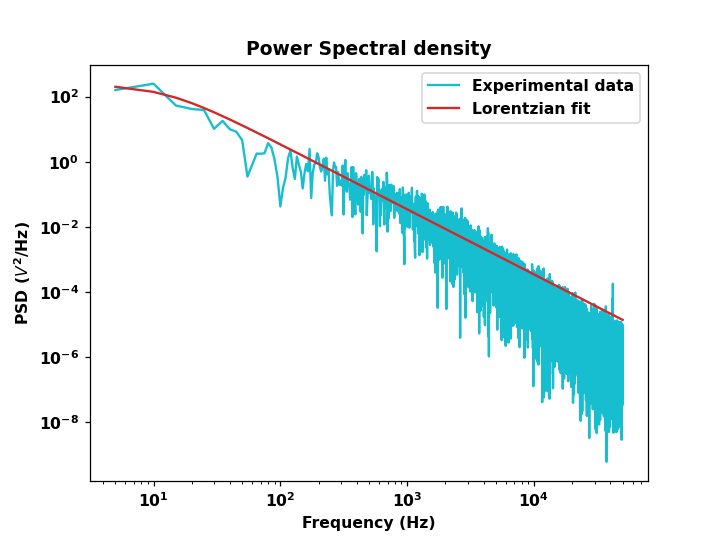

3.834857062544618e-05


In [106]:
from scipy.optimize import curve_fit  

def PSD(xdata, ydata, dt):
    
    freqs = np.fft.fftshift(fft.fftfreq(len(xdata),dt))
    
    index_pos_freqs = np.where(freqs>0.2)
    
    total_time = dt*len(xdata)
    
    PSD_x = np.abs(np.fft.fftshift(np.fft.fft(xdata)))**2/total_time/freqs
    PSD_y = np.abs(np.fft.fftshift(np.fft.fft(ydata)))**2/total_time/freqs
    
    return PSD_x[index_pos_freqs], PSD_y[index_pos_freqs], freqs[index_pos_freqs]


def Lorentzian(freq, S0, fcorte):       #Lorentzian function depends on this parameters 
    f=np.array(freq)                    #to be able to apply operations (+ / *)
    f0X=np.array(fcorte)
    #return  1/(S0*(1+(f+f0X)/S0)**2)    #How Lorentzian function is defined
    return 1/(S0*(f**2+f0X**2))   #wikipedia Lorentzian

#curve_fit() returns the optimal values; Gives an array which 1st element is an array with the adjustment parameters (popt)
#and the 2nd element is a 2d array with the covariance of the parameters (pcov -> estimated covariance of popt)
#popt ->Optimal values for the parameters so that the sum of the squared error of Lorentzian(xdata, *popt)- ydata is minimized

#Fit for the parameters S0 and fcorte of the function Lorentzian:

dt=10**-5
jj=1
kk=3
xdata=x_data[jj][kk]
ydata=y_data[jj][kk]


PSD_x, PSD_y, freqs = PSD (xdata,ydata,dt)

popt, pcov = curve_fit(Lorentzian, freqs, PSD_x) 

subplots()
#plot of the experimental data
plot(freqs, PSD_x, 'tab:cyan',label='Experimental data')
#plot of the Lorentz fit, where the ysignal, that is the Lorentzian function (return 1/(S0*(1+(f+f0)/S0)**2) 
#is plotted taking into account the Lorentzian(xdata, S0, f0) which corresponds 
plot(freqs, Lorentzian(freqs, *popt), 'tab:red',label='Lorentzian fit') #unpack values from popt ("tuple")
legend()
title("Power Spectral density")
xlabel("Frequency (Hz)")
ylabel("PSD ($V^2$/Hz)")
yscale("log") 
xscale("log")

S0,f0X =popt

a = 3*10e-6
gamma = 6*pi*eta*a
k = 2*pi*f0X*gamma
print(k)

# Plots of X, Y, Sum as segments

In [ ]:
subplots()
subplot(311)
ax1=gca()
t0=0
dt=10e-5
ind=1
i=0
i1=0

times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i3],color='gray',ls='-',lw=0.5)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
    

ax1.set_ylabel(r"$X(V)$")
ax1.set_xticklabels([])
    
    
xrange=t0
factorx=0.1
    
ax1.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax1.set_xticks([0,t0])
ax1.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(x_data[ind][0:3])-np.min(x_data[ind][0:3])
factor=0.1
    
ax1.set_ylim(np.min(x_data[ind][0:3])-factor*yrange,np.max(x_data[ind][0:3])+factor*yrange)
ax1.spines['left'].set_bounds(np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3]))
ax1.set_yticks([np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3])])
ax1.set_yticklabels([round(np.min(x_data[ind][0:3]),2),round(np.max(x_data[ind][0:3]),2)])

######################################################################################################
#######################################################################################################


subplot(312)
ax2=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i3],color='gray',ls='-',lw=0.5)


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
    

ax2.set_ylabel(r"$Y(V)$")
ax2.set_xticklabels([])
    
    
xrange=t0
factorx=0.1
    
ax2.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax2.set_xticks([0,t0])
ax2.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(y_data[ind][0:3])-np.min(y_data[ind][0:3])
factor=0.1
    
ax2.set_ylim(np.min(y_data[ind][0:3])-factor*yrange,np.max(y_data[ind][0:3])+factor*yrange)
ax2.spines['left'].set_bounds(np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3]))
ax2.set_yticks([np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3])])
ax2.set_yticklabels([round(np.min(y_data[ind][0:3]),2),round(np.max(y_data[ind][0:3]),2)])


######################################################################################################
#######################################################################################################

subplot(313)
ax3=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i3],color='gray',ls='-',lw=0.5)


ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
    

ax3.set_ylabel(r"$Sum(V)$")
ax3.set_xticklabels([0,round(t0,2)],fontsize=12)
    
    
xrange=t0
factorx=0.1
    
ax3.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax3.set_xticks([0,t0])
ax3.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(sum_data[ind][0:3])-np.min(sum_data[ind][0:3])
factor=0.1
    
ax3.set_ylim(np.min(sum_data[ind][0:3])-factor*yrange,np.max(sum_data[ind][0:3])+factor*yrange)
ax3.spines['left'].set_bounds(np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3]))
ax3.set_yticks([np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3])])
ax3.set_yticklabels([round(np.min(sum_data[ind][0:3]),2),round(np.max(sum_data[ind][0:3]),2)],fontsize=12)
ax3.set_xlabel(r"$t(s)$", fontsize=12)


savefig('images/Segments',dpi=300)
 

# PCA Plot

In [ ]:
from sklearn import *

ncomp=2


model = decomposition.PCA(n_components=ncomp)
model.fit(data_X)
PCs1 = model.transform(data_X)

model2 = decomposition.PCA(n_components=ncomp)
model2.fit(data_Y)
PCs2 = model2.transform(data_Y)

model3 = decomposition.PCA(n_components=ncomp)
model3.fit(data_Sum)
PCs3 = model3.transform(data_Sum)


label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]



In [ ]:
subplots(figsize=[10,12])
pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']

subplot(311)
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-40,40])
xlabel(r"$PC^{(X)}_1$",fontsize=16)
ylabel(r'$PC^{(X)}_2$',fontsize=16)
legend(fontsize=12,bbox_to_anchor=(0.4, 0.8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(312)
plot(PCs2[i0,pc1],PCs2[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs2[i1,pc1],PCs2[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs2[i2,pc1],PCs2[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs2[i3,pc1],PCs2[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs2[i4,pc1],PCs2[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs2[i5,pc1],PCs2[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-20,40])
xlabel(r"$PC^{(Y)}_1$",fontsize=16)
ylabel(r'$PC^{(Y)}_2$',fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(313)
plot(PCs3[i0,pc1],PCs3[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs3[i1,pc1],PCs3[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs3[i2,pc1],PCs3[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs3[i3,pc1],PCs3[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs3[i4,pc1],PCs3[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs3[i5,pc1],PCs3[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-30,90])
ax.set_xticks([-30,90])
ax.set_ylim([-65,70])
ax.set_yticks([-65,70])
xlabel(r"$PC^{(Sum)}_1$",fontsize=16)
ylabel(r'$PC^{(Sum)}_2$',fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])

savefig('images/PCA',dpi=300)

# Brownian Motion explore 2d

In [ ]:
from scipy.stats import *
%matplotlib notebook
subplots(figsize=[9,4])

end = 30000

for ind in range(0,len(x_data),6):
    subplot(3,len(x_data)/6,ind/6+1)
    
    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax = gca()
    ax.set_xticks([])
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_yticks([ymin,ymax])
        
        
    title(target_fix[ind])
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=0:
        ax = gca()
        ax.set_yticks([])
        
for ind in range(1,len(x_data),6):
    subplot(3,len(x_data)/6,6+ind/6+1)

    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax = gca()
    ax.set_xticks([])
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_yticks([ymin,ymax])
        
    
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=1:
        ax = gca()
        ax.set_yticks([])
        
for ind in range(5,len(x_data),6):
    subplot(3,len(x_data)/6,12+ind/6+1)

    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05
    
    ax=gca()
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_xticks([xmin,xmax])
        
    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=2:
        ax = gca()
        ax.set_yticks([])



In [ ]:
subplots()
ind=14
plot(ndarray.flatten(x_data[ind]),color='gray',ls='-',lw=0.5)

In [ ]:
%matplotlib notebook
subplots()
ind=0
init=1321613
end=1340000
x0 = ndarray.flatten(x_data[ind])[init]
#plot(ndarray.flatten(x_data[ind])[init:end],color='gray',ls='-',lw=0.5)
plot((ndarray.flatten(x_data[ind])[init:end]-x0)**2,color='gray',ls='-',lw=0.5)


In [ ]:
np.max((x_data[ind][0:3]))

In [ ]:
cv = np.correlate(x_data[ind][i],x_data[ind][i])
cv

In [ ]:
ind=0
i=0
j=132*2+2
cvs=[]
xm=x_data[ind][i]
diff = np.diff(xm) #this calculates r(t + dt) - r(t)
diff_sq = diff**2
MSD = (x_data[ind][i]-x_data[ind][i][0])**2
subplots()
plot0(MSD)

In [ ]:
MSD

In [ ]:
#Plots in FFT for X, Y, Sum as segments

In [ ]:
#Construct the 6-fold stratified crossvalidation set

def crossval_set(data_X, data_Y, data_Sum, target, particle_group, i):
    """
    Contructs stratified crossvalidation folds taking a particle with number i out and considering it as test
    """
    
    unique_particle_group = np.unique(particle_group)
    
    print("Particle group " + str(i))
        
    #select the test group and append to the lists
    index = np.where(np.array(particle_group) == unique_particle_group[i])[0]
        
    test_sets_data_X = data_X[index]
    test_sets_data_Y = data_Y[index]
    test_sets_data_Sum = data_Sum[index]
    test_sets_labels = target[index]
    test_particle_group = particle_group[index]
        
    #select the train group and append to the lists
    index = np.where(np.array(particle_group) != unique_particle_group[i])[0]
        
    train_sets_data_X = data_X[index]
    train_sets_data_Y = data_Y[index]
    train_sets_data_Sum = data_Sum[index]
    train_sets_labels = target[index]
    train_particle_group = particle_group[index]

    return train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group

In [ ]:
#Test model function
def test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                 test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                 unique_targets,
                 confusion_matrix = False, ncomp = 3):
    
    """
    Test a given model, returning accuracy results and confusion matrix
    """

    #Train the PC model and obtain the PCs_train projection
    PCs_train,pca_model = pca_data_construct_new_model(train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, ncomp=ncomp)
    
    #use the pca_model previously trained to project the test data
    PCs_test = pca_data_compute_from_previous_model(test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, pca_model, ncomp=ncomp)
    

    model.fit(PCs_train,train_sets_labels)
    score_train = model.score(PCs_train, train_sets_labels)
    score_test = model.score(PCs_test, test_sets_labels)

    #Generate a confusion matrix
    labels_pred = model.predict(PCs_train)
    conf_mat_train = metrics.confusion_matrix(train_sets_labels, labels_pred,normalize="true")
    
    #Generate a confusion matrix
    labels_pred = model.predict(PCs_test)
    conf_mat_pred = metrics.confusion_matrix(test_sets_labels, labels_pred,normalize="true")
        
    if confusion_matrix:
        metrics.ConfusionMatrixDisplay(conf_mat_train,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        metrics.ConfusionMatrixDisplay(conf_mat_pred,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        

        
        
        
    print("Model Accuracy -> " + str(np.mean(score_test)))
    return score_train, score_test,conf_mat_train,conf_mat_pred

In [ ]:
from tqdm import *


model_list_score_train=[]
model_list_score_test=[]
model_list_conf_train=[]
model_list_conf_test=[]

models_to_test=[ensemble.RandomForestClassifier(n_estimators=100,random_state=0), 
                neighbors.KNeighborsClassifier(30),
                svm.SVC(kernel="linear", C=0.25),
               linear_model.LogisticRegression(),
                neural_network.MLPClassifier(activation = 'tanh')]

pbar = tqdm(total=len(models_to_test)*len(np.unique(particle_group)))

for model in models_to_test:

    list_score_train =[]
    list_score_test = []
    list_conf_train = []
    list_conf_test = []
    print(model)
    
    
    for index in range(0,len(np.unique(particle_group))):
        pbar.update(1)
        
        train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group = crossval_set(data_X, data_Y, data_Sum, labels, particle_group,index)

        print(np.unique(train_particle_group), end= '\t')
        print(np.unique(test_particle_group))

        score_train, score_test, conf_train, conf_test = test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                     test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                     unique_targets,
                     confusion_matrix = False, ncomp = 2)

        list_score_train.append(score_train)
        list_score_test.append(score_test)
        list_conf_train.append(conf_train)
        list_conf_test.append(conf_test)
    

    model_list_score_train.append(list_score_train)
    model_list_score_test.append(list_score_test)
    model_list_conf_train.append(np.array(list_conf_train).mean(axis=0))
    model_list_conf_test.append(np.array(list_conf_test).mean(axis=0))
    
    

In [ ]:
%matplotlib notebook

unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um','$\mu$m'))

models_labels=['Random Forest', 
                       'K-Nearest Neighbors',
                       'Support Vector Machine Classifier',
                       'Logistic Regression',
                       'Multi-layer Perceptron']
    
    
    
for i in range(0,len(models_to_test)):
    print(models_to_test[i])
    print("Accuracy Train -> "+ str(mean(model_list_score_train[i])), end = '\t')
    print(str(max(model_list_score_train[i])), end = '\t')
    print(str(min(model_list_score_train[i])), end = '\n')
    
    print("Accuracy Test -> "+ str(mean(model_list_score_test[i])), end = '\t')
    print(str(max(model_list_score_test[i])), end = '\t')
    print(str(min(model_list_score_test[i])), end = '\n')
    
    
    conf_mat_pred = model_list_conf_test[i]
    metrics.ConfusionMatrixDisplay(np.round(conf_mat_pred,2),display_labels=unique_targets1).plot(cmap=cm.Blues)
    yticks(fontsize=6)
    xticks(fontsize=6)
    ax=gca()
    ax.set_title(models_labels[i])
    savefig('images//'+models_labels[i], bbox_inches='tight',dpi=300)
        